In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.discriminative_models import (
    LogisticRegression,
    MultilayerPerceptron,
)
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.plot_utils import (
    plot_classifier_decision_region,
    plot_generative_model_distribution,
    plot_observations,
    plot_counterfactuals,
    plot_arrows,
)

torch.manual_seed(0)

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def plot(ax, flow, disc_model, dataset, X_test, y_test, X_cf, prob_threshold):
    assert (
        X_test.shape == X_cf.shape
    ), f"Sizes of test set and counterfactuals are not equal. Actual sizes: X_test: {X_test.shape}, X_cf: {X_cf.shape}"
    assert (
        y_test.shape[0] == X_cf.shape[0]
    ), f"Sizes of targets and counterfactuals are not equal. Actual sizes: X_cf: {X_cf.shape}, y_test: {y_test.shape}"

    ax = plot_classifier_decision_region(ax, disc_model)
    ax = plot_generative_model_distribution(
        ax,
        flow,
        prob_threshold=prob_threshold,
        num_classes=len(np.unique(dataset.y_test)),
    )
    ax = plot_observations(ax, X_test, y_test)
    ax = plot_counterfactuals(ax, X_cf)
    ax = plot_arrows(ax, X_test, X_cf)
    # ax = plot_metrics_textbox(ax, metrics)
    return ax

/Users/ofurman/Study/counterfactuals/venv/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


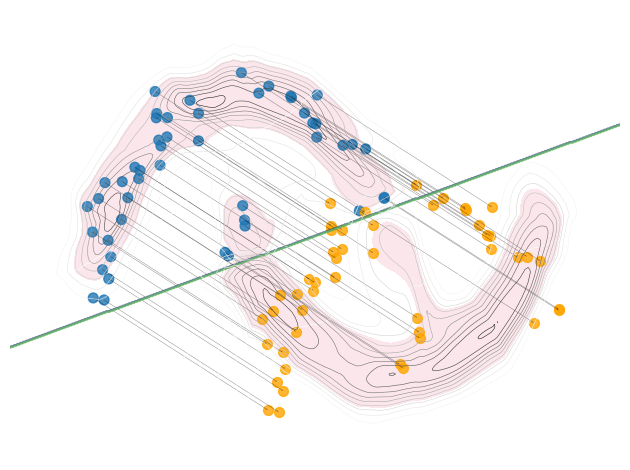

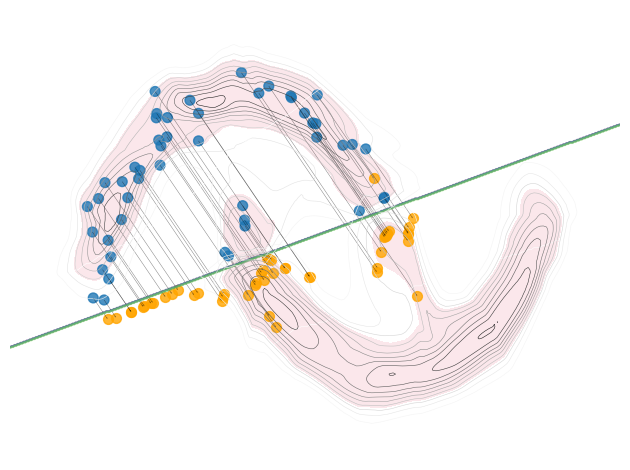

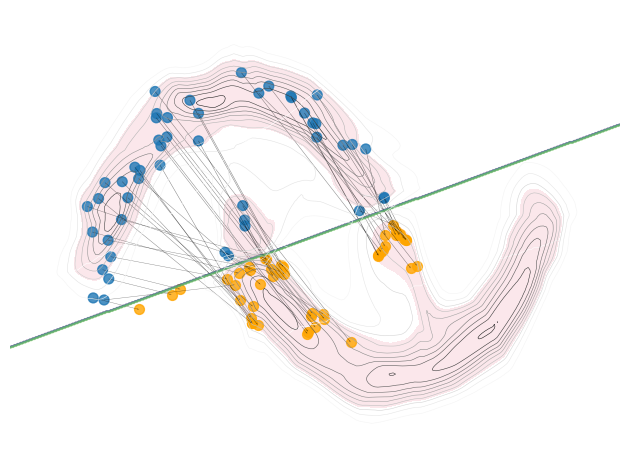

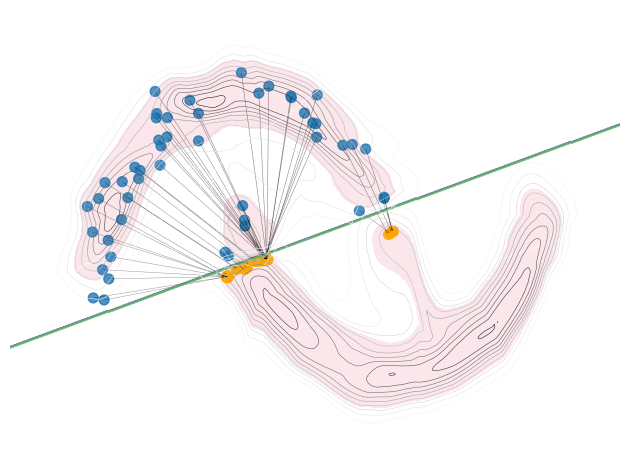

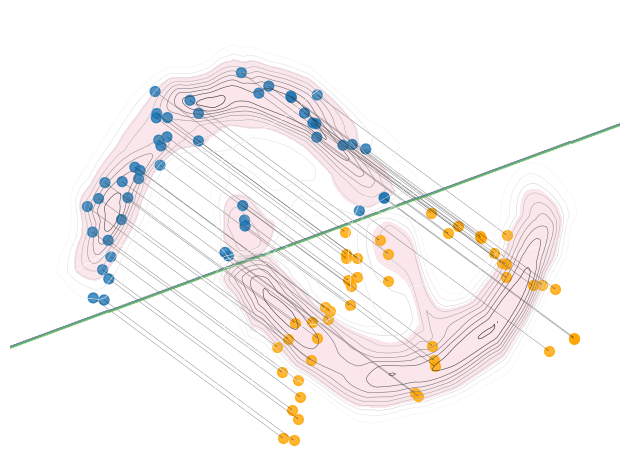

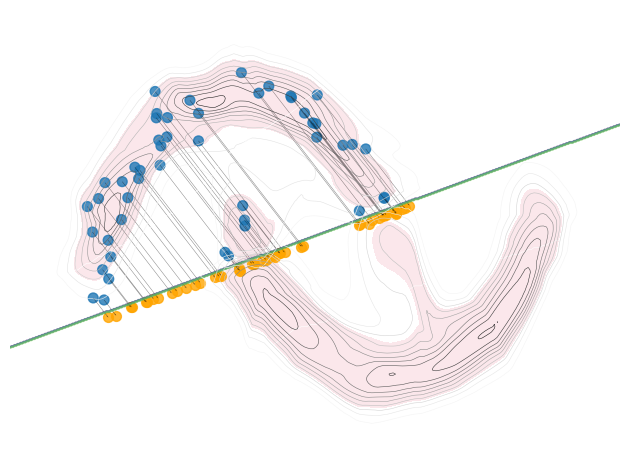

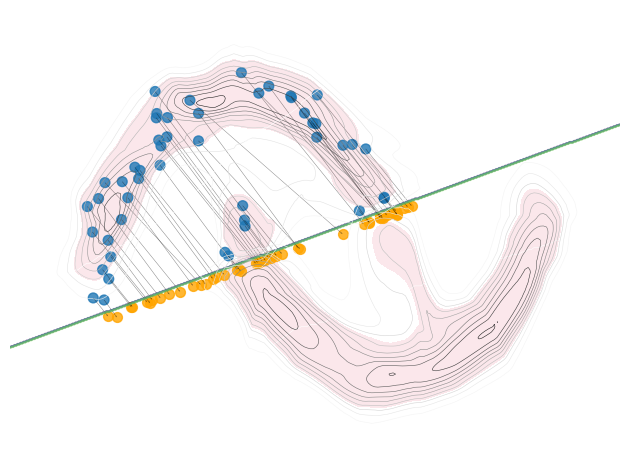

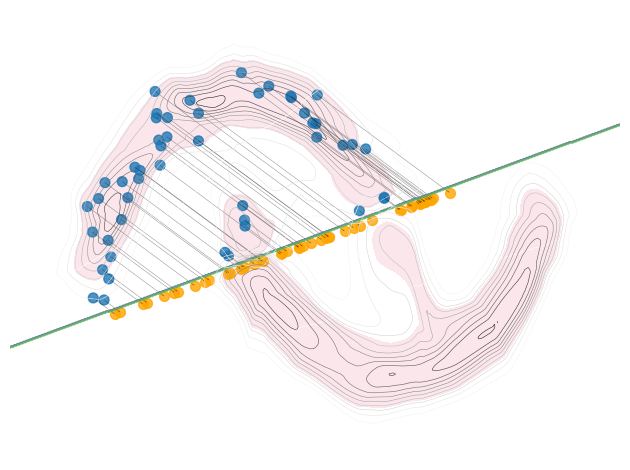

In [4]:
disc_model_name = "LogisticRegression"

dataset = MoonsDataset(file_path="../data/moons.csv")

disc_model = LogisticRegression(input_size=2, target_size=1)
disc_model.load(f"../models/MoonsDataset/disc_model_{disc_model_name}.pt")

flow = MaskedAutoregressiveFlow(
    features=2,
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.load(
    f"../models/MoonsDataset/gen_model_MaskedAutoregressiveFlow_relabeled_by_{disc_model_name}.pt"
)
log_prob_threshold = torch.quantile(
    flow.predict_log_prob(dataset.train_dataloader(1024, shuffle=False)), 0.25
)
log_prob_threshold

dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

origin_class = 0
target_class = np.abs(1 - origin_class)
X_test_origin = dataset.X_test[dataset.y_test == origin_class]
y_test_origin = dataset.y_test[dataset.y_test == origin_class]
X_test_target = dataset.X_test[dataset.y_test == target_class]
y_test_target = dataset.y_test[dataset.y_test == target_class]

rand_i = np.argwhere(np.random.rand(X_test_origin.shape[0]) > 0.5).flatten()

# fig, ax = plt.subplots(2, 4)
# fig.set_size_inches(18, 9)

method_mapping = {
    "ARES": "GCE",
    "GLOBAL_CE": "GCE w/ magnitude",
    "GCE": "Our",
    "PPCEF_2": "Wachter",
}

plausibility = {0: "plaus", 1: "no_plaus"}
plausibility_mapping = {"plaus": "w/ PP.", "no_plaus": "w/o PP."}
for i in range(2):
    for j, method in enumerate(["ARES", "GLOBAL_CE", "GCE", "PPCEF_2"]):
        X_cf = pd.read_csv(
            f"../models/MoonsDataset/GCE/counterfactuals_{plausibility[i]}_{method}_{disc_model_name}.csv"
        ).values
        # ax[i, j] = plot(ax[i, j], flow, disc_model, dataset, X_test_origin, y_test_origin, X_cf, log_prob_threshold)
        # ax[i, j].set_title(f"{method_mapping[method]} {plausibility_mapping[plausibility[i]]}")
        # # remove axes
        # ax[i, j].get_xaxis().set_visible(False)
        # ax[i, j].get_yaxis().set_visible(False)
        # # remove frame
        # ax[i, j].spines["top"].set_visible(False)
        # ax[i, j].spines["right"].set_visible(False)
        # ax[i, j].spines["bottom"].set_visible(False)
        # ax[i, j].spines["left"].set_visible(False)
        fig, ax = plt.subplots(1, 1)
        ax = plot(
            ax,
            flow,
            disc_model,
            dataset,
            X_test_origin[rand_i],
            y_test_origin[rand_i],
            X_cf[rand_i],
            log_prob_threshold,
        )
        # ax[i, j].set_title(f"{method_mapping[method]} {plausibility_mapping[plausibility[i]]}")
        # remove axes
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # remove frame
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        plt.tight_layout()

        plt.savefig(f"figure_{method}_{plausibility[i]}.pdf", dpi=300)
# plt.tight_layout()
# plt.savefig("all_methods_lr_model.pdf", dpi=300)

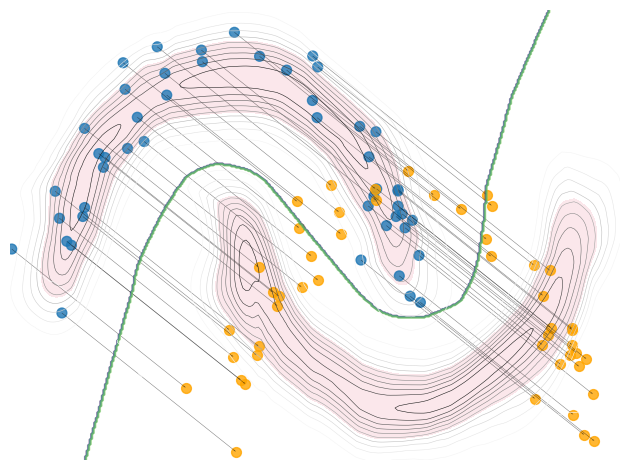

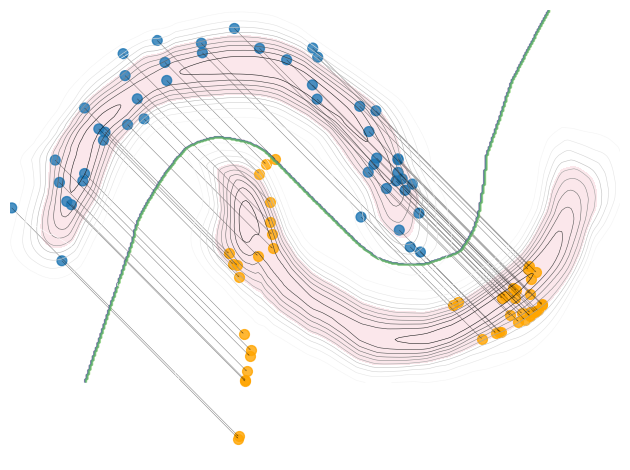

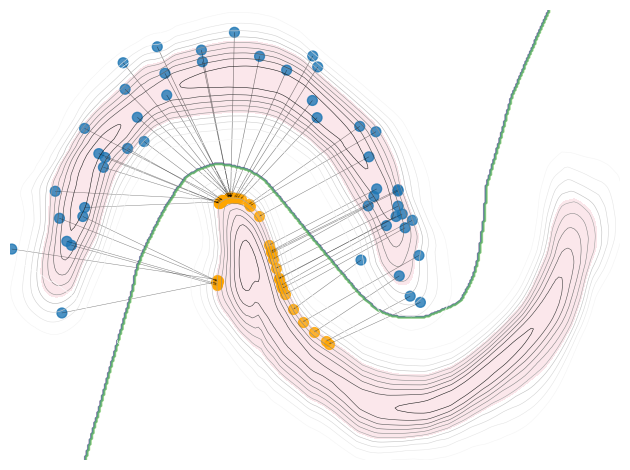

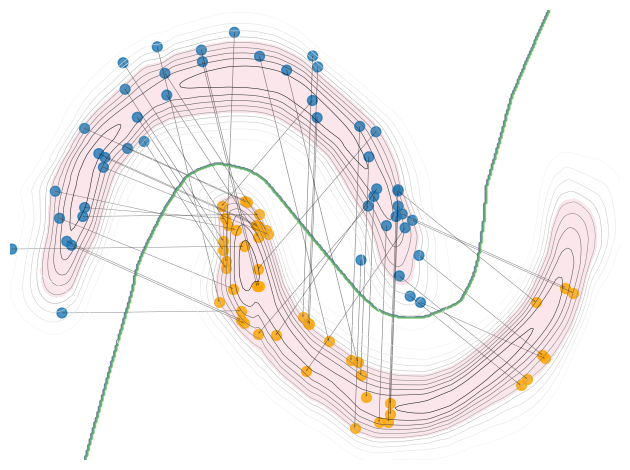

In [14]:
disc_model_name = "MultilayerPerceptron"

dataset = MoonsDataset(file_path="../data/moons.csv")

disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1
)
disc_model.load(f"../models/MoonsDataset/disc_model_{disc_model_name}.pt")
disc_model.eval()

flow = MaskedAutoregressiveFlow(
    features=2,
    hidden_features=16,
    num_blocks_per_layer=4,
    num_layers=8,
    context_features=1,
)
flow.load(
    f"../models/MoonsDataset/gen_model_MaskedAutoregressiveFlow_relabeled_by_{disc_model_name}.pt"
)
log_prob_threshold = torch.quantile(
    flow.predict_log_prob(dataset.train_dataloader(1024, shuffle=False)), 0.25
)
log_prob_threshold

dataset.y_train = disc_model.predict(dataset.X_train).detach().numpy()
dataset.y_test = disc_model.predict(dataset.X_test).detach().numpy()

origin_class = 0
target_class = np.abs(1 - origin_class)
X_test_origin = dataset.X_test[dataset.y_test == origin_class]
y_test_origin = dataset.y_test[dataset.y_test == origin_class]
X_test_target = dataset.X_test[dataset.y_test == target_class]
y_test_target = dataset.y_test[dataset.y_test == target_class]

rand_i = np.argwhere(np.random.rand(X_test_origin.shape[0]) > 0.5).flatten()

# fig, ax = plt.subplots(2, 4)
# fig.set_size_inches(18, 9)

method_mapping = {
    "ARES": "GCE",
    "GLOBAL_CE": "GCE w/ magnitude",
    "GCE": "Our",
    "PPCEF_2": "Wachter",
}

plausibility = {0: "plaus", 1: "no_plaus"}
plausibility_mapping = {"plaus": "w/ PP.", "no_plaus": "w/o PP."}
for i in range(1):
    for j, method in enumerate(["ARES", "GLOBAL_CE", "PPCEF_2", "GCE"]):
        X_cf = pd.read_csv(
            f"../models/MoonsDataset/GCE/counterfactuals_{plausibility[i]}_{method}_{disc_model_name}.csv"
        ).values
        # ax[i, j] = plot(ax[i, j], flow, disc_model, dataset, X_test_origin, y_test_origin, X_cf, log_prob_threshold)
        # ax[i, j].set_title(f"{method_mapping[method]} {plausibility_mapping[plausibility[i]]}")
        # # remove axes
        # ax[i, j].get_xaxis().set_visible(False)
        # ax[i, j].get_yaxis().set_visible(False)
        # # remove frame
        # ax[i, j].spines["top"].set_visible(False)
        # ax[i, j].spines["right"].set_visible(False)
        # ax[i, j].spines["bottom"].set_visible(False)
        # ax[i, j].spines["left"].set_visible(False)
        fig, ax = plt.subplots(1, 1)
        ax = plot(
            ax,
            flow,
            disc_model,
            dataset,
            X_test_origin[rand_i],
            y_test_origin[rand_i],
            X_cf[rand_i],
            log_prob_threshold,
        )
        # ax[i, j].set_title(f"{method_mapping[method]} {plausibility_mapping[plausibility[i]]}")
        # remove axes
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # remove frame
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        plt.tight_layout()

        plt.savefig(f"my_figure_{method}_{plausibility[i]}.pdf", dpi=300)

In [15]:
dx = X_cf - X_test_origin

In [16]:
np.unique(dx.round(2), axis=0, return_counts=True)

(array([[-0.19, -0.37],
        [-0.19, -0.31],
        [-0.18, -0.29],
        [-0.18, -0.28],
        [-0.17, -0.33],
        [-0.16, -0.32],
        [-0.15, -0.29],
        [-0.15, -0.24],
        [-0.15, -0.23],
        [-0.14, -0.29],
        [-0.13, -0.25],
        [-0.12, -0.24],
        [-0.09, -0.17],
        [-0.02, -0.58],
        [-0.02, -0.57],
        [-0.01, -0.52],
        [-0.01, -0.51],
        [-0.01, -0.49],
        [-0.01, -0.48],
        [-0.01, -0.47],
        [-0.01, -0.46],
        [-0.01, -0.45],
        [-0.01, -0.44],
        [-0.01, -0.43],
        [-0.01, -0.41],
        [-0.01, -0.37],
        [ 0.08, -0.45],
        [ 0.09, -0.52],
        [ 0.09, -0.5 ],
        [ 0.1 , -0.57],
        [ 0.11, -0.63],
        [ 0.11, -0.59],
        [ 0.12, -0.65],
        [ 0.13, -0.28],
        [ 0.14, -0.3 ],
        [ 0.14, -0.29],
        [ 0.15, -0.32],
        [ 0.15, -0.31],
        [ 0.16, -0.34],
        [ 0.16, -0.33],
        [ 0.17, -0.36],
        [ 0.17, 